In [1]:
!cp ../4thHandsOn/*.npy .

In [2]:
from scipy.io import loadmat
import numpy as np
from numpy import *
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pickle
from control import lqr, ss
from control.matlab import lsim
import random
from IPython.display import display, clear_output

import sklearn
import sklearn.pipeline

**The Tabular value-fucntion methods on the cart and pole system**

Consider the cart-and-pole system here depicted:
<div>
<img src="https://drive.google.com/uc?export=view&id=1Yu5zZ57OEEYZ678yWLaU7h-Wq3M9vV9E" width="200">
</div>
whose dynamics follows the following equations:

\begin{align}
  \ddot{\theta}&=\frac{g \sin(\theta)\,+\,\cos(\theta) \left[ \frac{-F\,-\,m_p\,l\,\dot{\theta}^2 \sin \left(\theta\right)}{m_c\,+\,m_p}\right]-\frac{\mu_p\dot{\theta}}{m_p\,l}}{l\,\left[\frac{4}{3}-\frac{m_p\,cos^2\left(\theta\right)}{m_c\,+\,m_p}\right]}
\end{align}
>>>>>>>>>>>>>>>>>>>>>>>>$(*)$

\begin{align}
  \ddot{p}_c&=\frac{F\,+\,m_p\,l\,\left[\dot{\theta}^2\,\sin\left(\theta\right)\,-\,\ddot{\theta}\,\cos(\theta)\right]}{m_c\,+\,m_p}
\end{align}

where $g = 9.8\,\text{m/sec}$ is the gravitational acceleration, $m_c = 1\,\text{kg}$ is the cart mass, $m_p = 0.1\,\text{kg}$ is the pole mass, $l = 0.5\,\text{m}$ is the half-pole length, $\mu_p = 0.000002$ is the pole on cart friction coefficient.

1. Given the $X$ set, select centers and standard deviation of RBFs and create a code that given a state $x$ returns $\phi\left(x,\cdot\right)$.

The pipeline will be the following:
1. normalize the data

In [3]:
def cart_and_pole_odeint(x, t, F):
  dxdt = np.zeros_like(x)

  dxdt[0] = x[1] #tetap
  dxdt[1] = (g*sin(x[0])+ cos(x[0])*((-F-m*l*(x[1]**2)*sin(x[0]))/(mc+m))-((miup*x[1])/(m*l))) / (l*((4/3)-((m*(cos(x[0])**2))/(mc+m))))    #teta2p
  dxdt[2] = x[3] #xp
  dxdt[3] = (F+m*l*((x[1]**2)*sin(x[0])-dxdt[1]*cos(x[0])))/(mc+m) #x2p
  return dxdt

g = 9.8 # gravitational acceleration
mc = 1  # cart mass [kg]
l = 0.5 # half-pole length [m]
m = 0.1 # pole mass [kg]
miup = 2e-6 # pole friction coefficient

time_step=0.02
t0_odeint=0
x0_odeint = np.array([np.deg2rad(1), 0.0, 0.0, 0.0]) # start out of equilibrium
X_odeint=[x0_odeint]

In [4]:
lowerBounds = [
    deg2rad(-25),
    -1,
    -5,
    -2
]
upperBounds = [- i for i in lowerBounds]
numberOfBins = [
    10,
    10,
    10,
    10
]

def discretize_state(state):
    angle    =      state[0]
    angularVelocity=state[1]
    position =      state[2]
    velocity =      state[3]

    poleAngleBin=np.linspace(lowerBounds[0],upperBounds[0],numberOfBins[0])
    poleAngleVelocityBin=np.linspace(lowerBounds[1],upperBounds[1],numberOfBins[1])
    cartPositionBin=np.linspace(lowerBounds[2],upperBounds[2],numberOfBins[2])
    cartVelocityBin=np.linspace(lowerBounds[3],upperBounds[3],numberOfBins[3])

    indexAngle=np.maximum(np.digitize(angle,poleAngleBin)-1,0)
    indexAngularVelocity=np.maximum(np.digitize(angularVelocity,poleAngleVelocityBin)-1,0)
    indexPosition=np.maximum(np.digitize(position,cartPositionBin)-1,0)
    indexVelocity=np.maximum(np.digitize(velocity,cartVelocityBin)-1,0)

    return tuple([indexAngle,indexAngularVelocity,indexPosition,indexVelocity])

def is_terminal_state(dstate):
    # discretized state
    if dstate[0] == 0 or dstate[0] == numberOfBins[0]-1:
        return True
    if dstate[2] == 0 or dstate[2] == numberOfBins[2]-1:
        return True
    return False

In [5]:
qtable = np.load("qtable.npy")

In [6]:
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

In [7]:
poleAngleBin=np.linspace(lowerBounds[0],upperBounds[0],numberOfBins[0])
poleAngleVelocityBin=np.linspace(lowerBounds[1],upperBounds[1],numberOfBins[1])
cartPositionBin=np.linspace(lowerBounds[2],upperBounds[2],numberOfBins[2])
cartVelocityBin=np.linspace(lowerBounds[3],upperBounds[3],numberOfBins[3])

observation_examples = []

for a in poleAngleBin:
    for b in poleAngleVelocityBin:
        for c in cartPositionBin:
            for d in cartVelocityBin:
                dstate = discretize_state([a,b,c,d])
                observation_examples.append(dstate)

In [8]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

StandardScaler()

In [9]:
featurizer = sklearn.pipeline.FeatureUnion([
    ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
    ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
    ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
    ("rbf4", RBFSampler(gamma=0.5, n_components=100))
])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(transformer_list=[('rbf1', RBFSampler(gamma=5.0)),
                               ('rbf2', RBFSampler(gamma=2.0)),
                               ('rbf3', RBFSampler()),
                               ('rbf4', RBFSampler(gamma=0.5))])

In [10]:
class Estimator:
    def __init__(self):
        self.models = [SGDRegressor(learning_rate="constant"), SGDRegressor(learning_rate="constant")]
    
    def featurize_state(self, state):
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def update(self, state, action, y):
        self.models[action].partial_fit([self.featurize_state(state)], [y])
        
    def predict(self, state):
        predictions = np.array([model.predict([self.featurize_state(state)]) for model in self.models])
        return predictions

In [11]:
estimator = Estimator()

In [12]:
qtable.shape

(10, 10, 10, 10, 2)

In [13]:
for i1 in range(10):
    for i2 in range(10):
        for i3 in range(10):
            for i4 in range(10):
                state = (i1,i2,i3,i4)
                for action in range(2):
                    estimator.update(state, action, qtable[state + (action,)])

2. Create a code that applies Q-Learning algorithm with function approximation

In [14]:
total_episodes = 1000
max_steps= 500
learning_rate = 0.01
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1.0                 # Exploration rate
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability 
decay_rate = 0.001             # Exponential decay rate for exploration prob

action_size = 2 # left or right

In [15]:
X_odeint = [x0_odeint]
uvec = []

state_c = x0_odeint
state = discretize_state(state_c)
total_rewards = 0

for step in range(max_steps):
    action = np.argmax(estimator.predict(state))

    # convert action into force
    if action == 1:
        F = 10
    else:
        F = -10
        
    uvec.append(F)

    # Simulate the system
    # new_state, reward, done, info, _ = env.step(action)
    t1_odeint = t0_odeint+0.02
    t_odeint = np.array([t0_odeint, t1_odeint])
    x_odeint = odeint(cart_and_pole_odeint, state_c, t_odeint, args=(F, ))
    new_state_c = x_odeint[1]
    new_state = discretize_state(new_state_c)
    X_odeint=np.append(X_odeint, [state_c], axis= 0)

    if is_terminal_state(new_state):
        reward = -100
    else:
        reward = 1

    # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    # qtable[new_state,:] : all the actions we can take from new state
    # qtable[state + (action,)] = qtable[state + (action,)] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state + (action,)])

    total_rewards =total_rewards + reward

    # Our new state is state
    state = new_state
    state_c = new_state_c

    # If done (if we're dead) : finish episode
    if is_terminal_state(new_state):
        break

Time: 6.5200000000000005


Text(0.5, 1.0, 'dot p_c(t)')

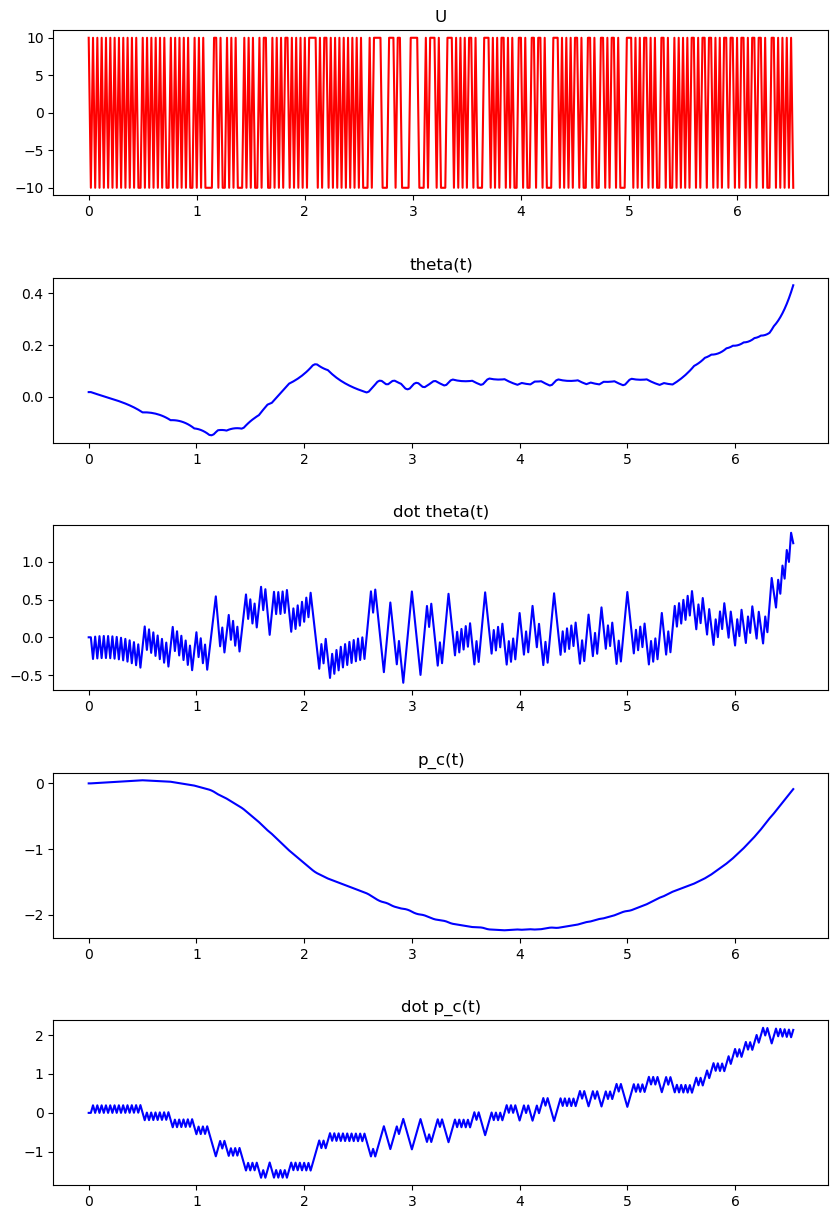

In [16]:
print("Time:", np.arange(0.0, 10, time_step)[:len(uvec)][-1])
time_sim=np.arange(0.0, 10+time_step, time_step)

plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(5)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(np.arange(0.0, 10, time_step)[:len(uvec)], uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim[:X_odeint[:,0].shape[0]], X_odeint[:,0], 'b')
axs[1].set_title("theta(t)")

axs[2].plot(time_sim[:X_odeint[:,1].shape[0]], X_odeint[:,1], 'b')
axs[2].set_title("dot theta(t)")

axs[3].plot(time_sim[:X_odeint[:,2].shape[0]], X_odeint[:,2], 'b')
axs[3].set_title("p_c(t)")

axs[4].plot(time_sim[:X_odeint[:,3].shape[0]], X_odeint[:,3], 'b')
axs[4].set_title("dot p_c(t)")

The linearised version is having a lower performance, but this has to be expected since it's a further approximation that we are taking into account.

3. Copy and paste your Q-learning algorithm with function approximation and apply the changes needed to convert it into a SARSA algorithm with function approximation


In [17]:
qtable_sarsa = np.load("qtable_sarsa.npy")

In [18]:
estimator_sarsa = Estimator()

In [19]:
for i1 in range(10):
    for i2 in range(10):
        for i3 in range(10):
            for i4 in range(10):
                state = (i1,i2,i3,i4)
                for action in range(2):
                    estimator_sarsa.update(state, action, qtable[state + (action,)])

In [20]:
X_odeint = [x0_odeint]
uvec = []

state_c = x0_odeint
state = discretize_state(state_c)
total_rewards = 0

for step in range(max_steps):
    action = np.argmax(estimator_sarsa.predict(state))

    # convert action into force
    if action == 1:
        F = 10
    else:
        F = -10
        
    uvec.append(F)

    # Simulate the system
    # new_state, reward, done, info, _ = env.step(action)
    t1_odeint = t0_odeint+0.02
    t_odeint = np.array([t0_odeint, t1_odeint])
    x_odeint = odeint(cart_and_pole_odeint, state_c, t_odeint, args=(F, ))
    new_state_c = x_odeint[1]
    new_state = discretize_state(new_state_c)
    X_odeint=np.append(X_odeint, [state_c], axis= 0)

    if is_terminal_state(new_state):
        reward = -100
    else:
        reward = 1

    total_rewards =total_rewards + reward

    # Our new state is state
    state = new_state
    state_c = new_state_c

    # If done (if we're dead) : finish episode
    if is_terminal_state(new_state):
        break

Time: 6.5200000000000005


Text(0.5, 1.0, 'dot p_c(t)')

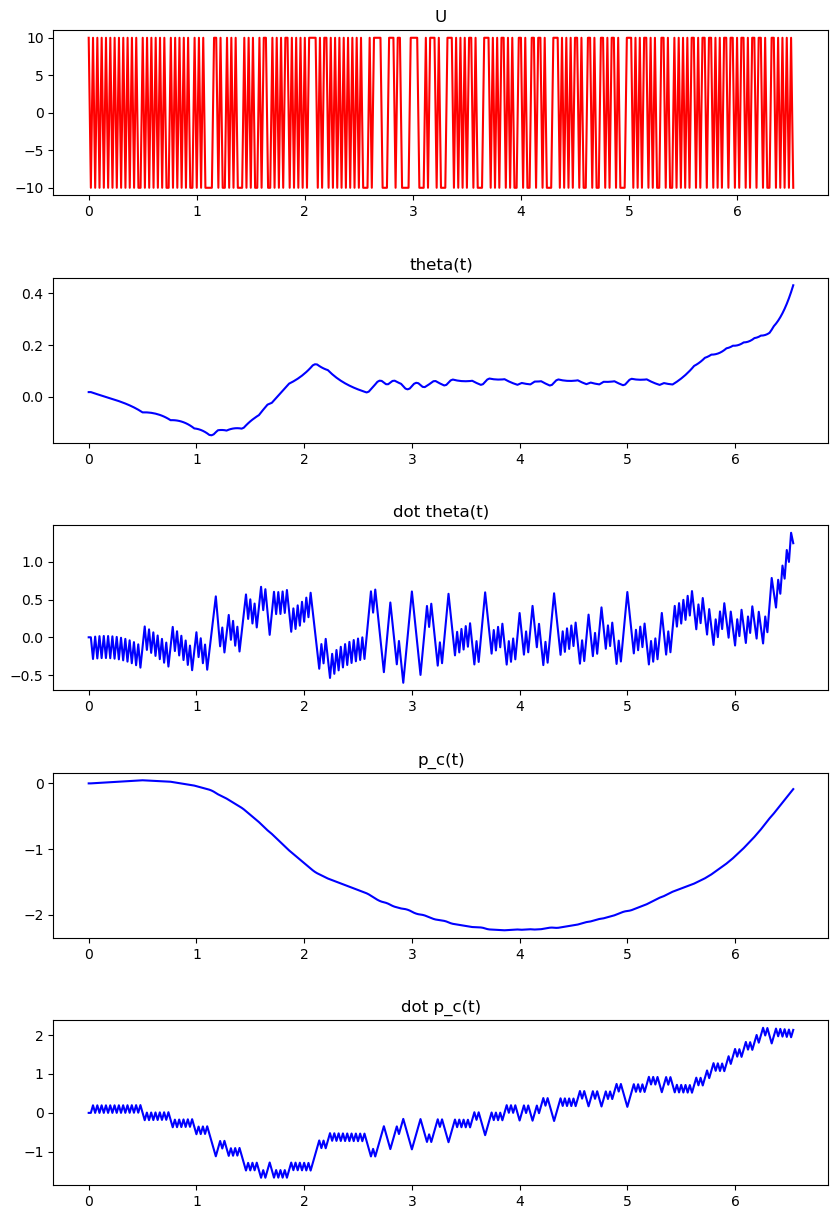

In [21]:
print("Time:", np.arange(0.0, 10, time_step)[:len(uvec)][-1])
time_sim=np.arange(0.0, 10+time_step, time_step)

plt.rcParams['figure.figsize'] = [10, 15]
fig, axs = plt.subplots(5)
fig.subplots_adjust(hspace=0.5)

axs[0].plot(np.arange(0.0, 10, time_step)[:len(uvec)], uvec, 'r', label='U(t)')
axs[0].set_title("U")

axs[1].plot(time_sim[:X_odeint[:,0].shape[0]], X_odeint[:,0], 'b')
axs[1].set_title("theta(t)")

axs[2].plot(time_sim[:X_odeint[:,1].shape[0]], X_odeint[:,1], 'b')
axs[2].set_title("dot theta(t)")

axs[3].plot(time_sim[:X_odeint[:,2].shape[0]], X_odeint[:,2], 'b')
axs[3].set_title("p_c(t)")

axs[4].plot(time_sim[:X_odeint[:,3].shape[0]], X_odeint[:,3], 'b')
axs[4].set_title("dot p_c(t)")

For the sarsa we are also seeing a lower performance, but this time from being able to balance for 4.6s we are getting worse and only able to balance for 2s